In [5]:
import pyms
import numpy as np
import torch
import time
from pyms.Probe import aberration
from copy import deepcopy
import matplotlib.pyplot as plt

from pyms.utils.torch_utils import (
    amplitude,
    crop_to_bandwidth_limit_torch,
    size_of_bandwidth_limited_array,
    amplitude,
)

from pyms.Probe import (
    make_contrast_transfer_function,
)

%matplotlib inline

crystal = pyms.structure.fromfile(
    "Structures/SrTiO3_CeO2_interface.xyz", atomic_coordinates="cartesian"
)

# A few maniupulations to remove vaccuum at edges and create a psuedo-periodic structure
crystal = crystal.resize([0.1, 0.76], axis=0)

other = deepcopy(crystal).resize([0.017, 0.99], axis=0)
other.reflect([0])
crystal = crystal.concatenate(other, axis=0)

# Subslicing of crystal for multislice
subslices = [0.33, 0.66, 1.0]

# Grid size in pixels
gridshape = [1024, 1024]

# Tile structure in multislice for a square grid
tiling = [1, 7]

# Probe accelerating voltage in eV
eV = 3e5

# Objective aperture in mrad
app = 15

# No aperture is also an option
# app = None

# Set up series of thicknesses
thicknesses = np.array([100])


In [6]:
# Establish aberrations

def establish_aberrations():
    """Create a list of aberrations. Initialise with starting values."""

    aberrations = []

    # Initial guesses for aberrations
    df = 100.0
    A1 = 10.0
    A2 = 10.0
    B2 = 10.0
    Cs= 10.0
    A3 = 10.0
    S3 = 10.0
    A4 = 10.0
    D4 = 10.0
    B4 = 10.0
    C5 = 10.0
    A5 = 10.0
    S5 = 10.0
    R5 = 10.0

    # Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
    # n and m are constants (shouldn't be differentiable), amplitude and angle should be

    aberrations.append(aberration("C10", "C1", "Defocus          ", torch.tensor([df], requires_grad = True), 0.0, 1, 0.0))
    aberrations.append(aberration("C12", "A1", "2-Fold astig.    ", torch.tensor([A1], requires_grad = True), 0.0, 1, 0.0)) # changed angle to a value (5) but made no difference so changed i back to 0
    aberrations.append(aberration("C23", "A2", "3-Fold astig.    ", torch.tensor([A2], requires_grad = True), 0.0, 2, 3.0))
    aberrations.append(aberration("C21", "B2", "Axial coma       ", torch.tensor([B2], requires_grad = True), 0.0, 2, 1.0))
    aberrations.append(aberration("C30", "C3", "3rd order spher. ", torch.tensor([Cs], requires_grad = True), 0.0, 3, 0.0))
    aberrations.append(aberration("C34", "A3", "4-Fold astig.    ", torch.tensor([A3], requires_grad = True), 0.0, 3, 4.0))
    aberrations.append(aberration("C32", "S3", "Axial star aber. ", torch.tensor([S3], requires_grad = True), 0.0, 3, 2.0))
    aberrations.append(aberration("C45", "A4", "5-Fold astig.    ", torch.tensor([A4], requires_grad = True), 0.0, 4, 5.0))
    aberrations.append(aberration("C43", "D4", "3-Lobe aberr.    ", torch.tensor([D4], requires_grad = True), 0.0, 4, 3.0))
    aberrations.append(aberration("C41", "B4", "4th order coma   ", torch.tensor([B4], requires_grad = True), 0.0, 4, 1.0))
    aberrations.append(aberration("C50", "C5", "5th order spher. ", torch.tensor([C5], requires_grad = True), 0.0, 5, 0.0))
    aberrations.append(aberration("C56", "A5", "6-Fold astig.    ", torch.tensor([A5], requires_grad = True), 0.0, 5, 6.0))
    aberrations.append(aberration("C52", "S5", "5th order star   ", torch.tensor([S5], requires_grad = True), 0.0, 5, 2.0))
    aberrations.append(aberration("C54", "R5", "5th order rosette", torch.tensor([R5], requires_grad = True), 0.0, 5, 4.0))

    defocus = aberrations[0].amplitude
    
    return aberrations


In [7]:
# Set up our initial guess for the crystal HRTEM
# It uses the aberrations (including defocus) as set above

def create_initial_guess(aberrations):

    output = pyms.HRTEM(
        crystal,
        gridshape,
        eV,
        app,
        thicknesses,
        subslices=subslices,
        aberrations=aberrations,
        df= aberrations[0].amplitude,
        tiling=tiling,
        nfph=1,
        showProgress='notebook', 
        apply_ctf = False,
    )
    #plt.imshow(torch.abs(output).detach().cpu().numpy(), vmax = 10)
    
    return output

Let's do several experiments:
1. How does the loss and time to train vary with number of iterations? At what point does it stagnate?
2. How does the initial starting value of the aberrations affect the optimisation of the defocus value?
3. How does the performance vary with optimiser? (currently Adam)

## Task 1: effect of number of iterations on loss and time

In [14]:
def optimise(aberrations, output, ref_data, n_iters):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    # Generic form allows more flexibility if we decided to not include some aberrations in the future.
    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([]) # create a curve for each differentiable quantity

    optimizer = torch.optim.Adam(params, lr = 1e-1)
    criterion = torch.nn.MSELoss()
    
    #n_iters = 2000

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*1000000000

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()

    print("Time to run:", str((end - start)))
    print("Loss", str(loss.item())) # Final loss value
    print("Final defocus value", str(aberrations[0].amplitude.item()))

In [5]:
def main(n_iter):
    aberrations = establish_aberrations()
    output = create_initial_guess(aberrations)
    
    # Load in "experimental" data
    path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'
    ref_data = np.load(path)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    optimise(aberrations, output, ref_data, n_iter)
    

In [6]:
main(10)
main(100)
main(1000)
main(2000)
main(5000)
main(10000)

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/pyms/Premixed_routines.py:1520: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for df_ in defocii


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

/home/hremadmin/miniconda3/envs/pyms_2/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([683, 683])) that is different to the input size (torch.Size([1, 683, 683])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Time to run: 0.7270116806030273
Loss 0.0029995360724306037
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 6.7720046043396
Loss 0.0024479168602273625
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 68.77355885505676
Loss 0.0009811864824772311
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 141.9217939376831
Loss 0.0009530550099200214
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 349.62275075912476
Loss 0.0009682134506680149
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 705.4273769855499
Loss 0.0009162577932571209


In [7]:
times = [
    0.727011680603027,
    6.7720046043396,
    68.7735588550568,
    141.921793937683,
    349.622750759125,
    705.42737698555
        ]

losses = [
    0.002999536072431,
    0.002447916860227,
    0.000981186482477,
    0.00095305500992,
    0.000968213450668,
    0.000916257793257
]

iterations = [
    10,
    100,
    1000,
    2000,
    5000,
    10000
]


! Wish I had also got the final defocus values so I could see how close we get to the GT for each number of iterations.

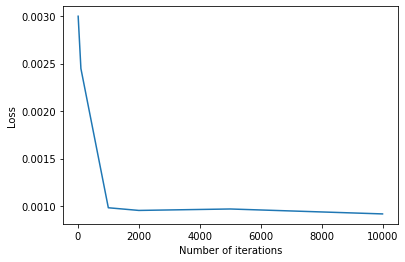

In [9]:
plt.plot(iterations, losses)
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.show()

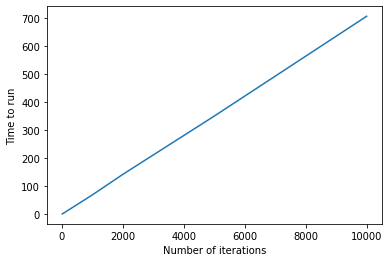

In [10]:
plt.plot(iterations, times)
plt.ylabel('Time to run')
plt.xlabel('Number of iterations')
plt.show()

From this we can see there is no real point iterating past 1000 cycles FOR THIS PARTICULAR SET UP. It may be different for different optimiser functions.

## Task 2: effect of starting values of aberrations on success of optimising the defocus

Reset the number of iterations to be a constant (2000). Manually change the values of the aberrations starting values then run each time. <br>
Find the final value of the defocus- the ground truth is 200? <br>
Plot the defocus value against initial aberration value- will have to set all aberrations equal to the same value for comparison.

In [8]:
# Establish aberrations

def establish_aberrations(ab):
    """Create a list of aberrations. Initialise with starting values."""

    aberrations = []

    # Initial guesses for aberrations
    df = 1000.0 # changed to 1000 from 100
    
    A1 = ab
    A2 = ab 
    B2 = ab
    Cs = ab
    A3 = ab
    S3 = ab
    A4 = ab
    D4 = ab
    B4 = ab
    C5 = ab
    A5 = ab
    S5 = ab
    R5 = ab

    # Krivanek aberration coefficient, Haider aberration coefficient, colloquial name, amplitude, angle, n, m
    # n and m are constants (shouldn't be differentiable), amplitude and angle should be

    aberrations.append(aberration("C10", "C1", "Defocus          ", torch.tensor([df], requires_grad = True), 0.0, 1, 0.0))
    aberrations.append(aberration("C12", "A1", "2-Fold astig.    ", torch.tensor([A1], requires_grad = True), 0.0, 1, 0.0)) # changed angle to a value (5) but made no difference so changed i back to 0
    aberrations.append(aberration("C23", "A2", "3-Fold astig.    ", torch.tensor([A2], requires_grad = True), 0.0, 2, 3.0))
    aberrations.append(aberration("C21", "B2", "Axial coma       ", torch.tensor([B2], requires_grad = True), 0.0, 2, 1.0))
    aberrations.append(aberration("C30", "C3", "3rd order spher. ", torch.tensor([Cs], requires_grad = True), 0.0, 3, 0.0))
    aberrations.append(aberration("C34", "A3", "4-Fold astig.    ", torch.tensor([A3], requires_grad = True), 0.0, 3, 4.0))
    aberrations.append(aberration("C32", "S3", "Axial star aber. ", torch.tensor([S3], requires_grad = True), 0.0, 3, 2.0))
    aberrations.append(aberration("C45", "A4", "5-Fold astig.    ", torch.tensor([A4], requires_grad = True), 0.0, 4, 5.0))
    aberrations.append(aberration("C43", "D4", "3-Lobe aberr.    ", torch.tensor([D4], requires_grad = True), 0.0, 4, 3.0))
    aberrations.append(aberration("C41", "B4", "4th order coma   ", torch.tensor([B4], requires_grad = True), 0.0, 4, 1.0))
    aberrations.append(aberration("C50", "C5", "5th order spher. ", torch.tensor([C5], requires_grad = True), 0.0, 5, 0.0))
    aberrations.append(aberration("C56", "A5", "6-Fold astig.    ", torch.tensor([A5], requires_grad = True), 0.0, 5, 6.0))
    aberrations.append(aberration("C52", "S5", "5th order star   ", torch.tensor([S5], requires_grad = True), 0.0, 5, 2.0))
    aberrations.append(aberration("C54", "R5", "5th order rosette", torch.tensor([R5], requires_grad = True), 0.0, 5, 4.0))

    defocus = aberrations[0].amplitude
    
    return aberrations


In [80]:
def main(n_iter, ab):
    aberrations = establish_aberrations(ab)
    output = create_initial_guess(aberrations)
    
    # Load in "experimental" data
    path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'
    ref_data = np.load(path)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    optimise(aberrations, output, ref_data, n_iter)
    

In [17]:
main(2000, 0.0) # GT
main(2000, 0.1)
main(2000, 1.0)
main(2000, 5.0)
main(2000, 10.0)
main(2000, 15.0)
main(2000, 50.0)
main(2000, 100.0)
main(2000, 500.0) # very far from GT

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 139.9329674243927
Loss 0.0009486335655733365
Final defocus value 148.64747619628906
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 144.19004130363464
Loss 0.0009316892185231219
Final defocus value 148.90408325195312
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 141.2671251296997
Loss 0.0009362766277316426
Final defocus value 148.9773712158203
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 151.87974166870117
Loss 0.0009606355214040904
Final defocus value 145.81320190429688
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 141.20959329605103
Loss 0.0009905324431741997
Final defocus value 143.00738525390625
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 145.59288263320923
Loss 0.000986376912096791
Final defocus value 141.4766082763672
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 150.5241560935974
Loss 0.0009559109504712882
Final defocus value 123.33446502685547
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 146.4284725189209
Loss 0.0009472537804121355
Final defocus value 98.72237396240234
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 145.2394094467163
Loss 0.0018747406971148677
Final defocus value 93.12620544433594


In [21]:
# The defocus ground truth is 200, the aberration ground truth is 0

aberration_values = [
    0.0,
    0.1,
    1.0,
    5.0,
    10.0,
    15.0,
    50.0,
    100.0,
    500 
]

final_defocus_value = [
    148.64747619628906,
    148.90408325195312,
    148.9773712158203,
    145.81320190429688,
    143.00738525390625,
    141.4766082763672,
    123.33446502685547,
    98.72237396240234,
    93.12620544433594   
]

times = [
    139.9329674243927,
    144.19004130363464,
    141.2671251296997,
    151.87974166870117,
    141.20959329605103,
    145.59288263320923,
    150.5241560935974,
    146.4284725189209,
    145.2394094467163
]

losses = [
    0.0009486335655733365,
    0.0009316892185231219,
    0.0009362766277316426,
    0.0009606355214040904,
    0.0009905324431741997,
    0.000986376912096791,
    0.0009559109504712882,
    0.0009472537804121355,
    0.0018747406971148677
]

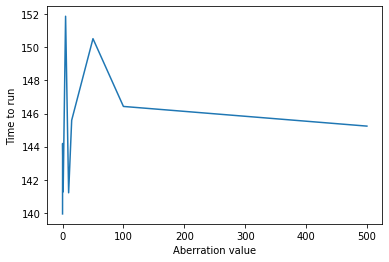

In [22]:
plt.plot(aberration_values, times)
plt.ylabel('Time to run')
plt.xlabel('Aberration value')
plt.show()

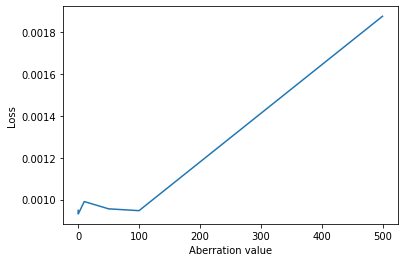

In [23]:
plt.plot(aberration_values, losses)
plt.ylabel('Loss')
plt.xlabel('Aberration value')
plt.show()

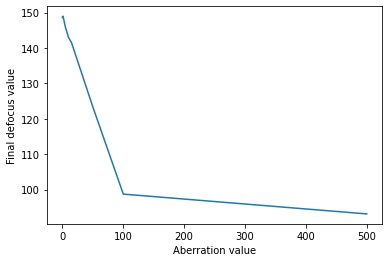

In [24]:
plt.plot(aberration_values, final_defocus_value)
plt.ylabel('Final defocus value')
plt.xlabel('Aberration value')
plt.show()

Summary: <br>
- Unsurprisingly, the closer the aberrations were to <i>their</i> ground truth, the more the algorithm was able to focus on getting the right value for the defocus (the closer to the defocus ground truth).
- Time to run was pretty independent (as unexpected)
- Loss generally increased as the guess for the aberration got further from the ground truth. There was a slight dip at a value of 100- unsure why.

## Task 3: Different optimisers

Change the code to use different types of optimisers. Keep the aberration value and number of iterations constant, monitor the time to run and the loss.

In [138]:
def optimise(aberrations, output, ref_data, n_iters):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    # Generic form allows more flexibility if we decided to not include some aberrations in the future.
    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([]) # create a curve for each differentiable quantity

    optimizer = torch.optim.RAdam(params, lr = 1e-1)
    criterion = torch.nn.MSELoss()
    
    #n_iters = 2000

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*1000000000

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()

    print("Time to run:", str((end - start)))
    print("Loss", str(loss.item())) # Final loss value
    print("Final defocus value", str(aberrations[0].amplitude.item()))

In [139]:
main(10000, 50.0)

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 761.6669464111328
Loss 0.0017584600743793747
Final defocus value 962.4739990234375


In [99]:
optimizer = [
    'Adam',
    'Adadelta',
    'Adagrad',
    'AdamW',
    'Adamax',
    'ASGD',
    'NAdam',
    'RAdam',
    'RMSprop',
    'Rprop',
    'SGD'
]
# Note; couldn't do 'SparseAdam' as "SparseAdam does not support dense gradients, please consider Adam instead"
# LBFGS had error "step() missing 1 required positional argument: 'closure'"- not including it
# 

time = [
    150.1419723033905,
    140.10347938537598,
    139.20631313323975,
    139.54891061782837,
    140.95341897010803,
    144.2091224193573,
    142.90306091308594,
    147.3002107143402,
    139.54793071746826,
    142.1045479774475,
    146.97593665122986
    
]

losses = [
    0.0009979652666608923,
    0.002927080800590592,
    0.0024215826616612647,
    0.0012101008351774493,
    0.0009496943040385716,
    0.0029332439371796298,
    0.0009047274980463242,
    0.0009727074798596515,
    0.0009749151426093984,
    0.0009507312501784597,
    0.002860806129985016
    
]

final_defocus_value = [
    144.4311065673828,
    100,
    109.00341796875,
    91.6656723022461,
    145.1249237060547,
    98.03470611572266,
    144.4785919189453,
    144.04559326171875,
    144.02845764160156,
    145.25015258789062,
    100.0
    
]

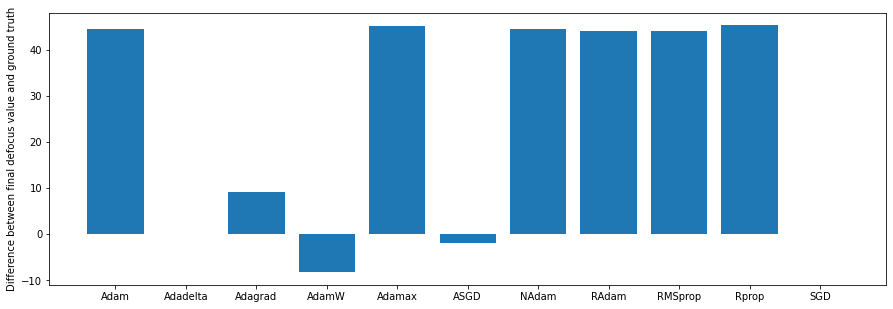

In [72]:
plt.figure(figsize=(15,5))

y_data = [i-100 for i in final_defocus_value]

plt.bar(optimizer, y_data)
plt.ylabel('Difference between final defocus value and ground truth')
plt.
plt.show()

# rainbow colormap
# I'd like a colour corresponding to the height

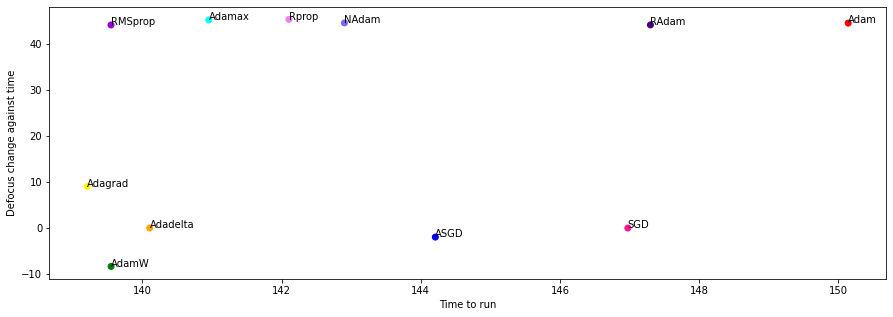

In [124]:
#plt.figure(figsize=(15,5))
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)

y_data = [i-100 for i in final_defocus_value]

plt.scatter(time, y_data, c=['red', 'orange', 'yellow', 
                             'green', 'cyan', 'blue', 'mediumslateblue',
                             'indigo', 'darkviolet', 'violet',
                             'deeppink'])



for i, txt in enumerate(optimizer):
    ax.annotate(txt, (time[i], y_data[i]))
    
plt.ylabel('Defocus change against time')
plt.xlabel('Time to run')
plt.show()

#fig.savefig("test.png")

# Ideal is top left, see RMSprop is giving best values

Each optimizer algorithm also has different parameters that can be adjusted, for example 'momentum' in SGD so might be interesting to play around with different values of that.

Reattempt these findings with the top performing algorithsm (RMSprop, Adamax, Rprop, Nadam, RAdam and Adam) but for a larger number of iterations and starting the defocus from a further away value. <br>
Use 10000 iterations and a defocus of 1000 and aberrations of 50?

In [ ]:
optimizer = [
    'RMSprop',
    'Adamax',
    'Rprop',
    'NAdam',
    'RAdam',
    'Adam'
]

time = [
    742.9264283180237,
    745.1832458972931,
    755.1761360168457,
    762.3292775154114
    
]

losses = [
    0.001753168555034069,
    0.001616753539961251,
    0.0015940609236230977,
    0.001648667013519778
    
]

final_defocus_value = [
    962.500244140625,
    960.6928100585938,
    954.0565795898438,
    962.8516235351562
]


## Task 4: Different loss criterion

In [97]:
def optimise(aberrations, output, ref_data, n_iters):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    # Generic form allows more flexibility if we decided to not include some aberrations in the future.
    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([]) # create a curve for each differentiable quantity

    optimizer = torch.optim.Adam(params, lr = 1e-1)
    criterion = torch.nn.BCELoss()
    
    #n_iters = 2000

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()

        loss = criterion(sim_image, ref_data)*1000000000

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()

    print("Time to run:", str((end - start)))
    print("Loss", str(loss.item())) # Final loss value
    print("Final defocus value", str(aberrations[0].amplitude.item()))

In [98]:
main(2000, 10.0)

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Using a target size (torch.Size([683, 683])) that is different to the input size (torch.Size([1, 683, 683])) is deprecated. Please ensure they have the same size.

I'm not sure if this is worth continuing because the MSELoss criterion is clearly the best one in this case.

In [ ]:
criterion = [
    'L1Loss',
    'MSELoss',
    'PoissonNLLLoss',
    'KLDivLoss',
    'MarginRankingLoss',
    'HingeEmbeddingLoss',
    'MultiLabelMarginLoss',
    'HuberLoss',
    'SmoothL1Loss',
    'SoftMarginLoss',
    'MultiLabelSoftMarginLoss',
    'CosineEmbeddingLoss',
    'MultiMarginLoss',
    'TripletMarginLoss',
    'TripleMarginWithDistanceLoss'
]

# CrossEntropyLoss, CTCLoss, NLLLoss having issues
# Error essage: "ValueError: Expected input batch_size (1) to match target batch_size (683)."

# GaussianNLLLoss
# forward() missing 1 required positional argument: 'var'

# BCELoss or BCEWithDigitsLoss?


time = [
    141.36087346076965,
    141.07798957824707,
    150.28406143188477,
    146.84250020980835,
    
]

losses = [
    738.5678858124206,
    0.0009510623532634575,
    1000001740.2282532,
    -22698.204008929904,
    
    
]

final_defocus_value = [
    143.10873413085938,
    144.5781707763672,
    144.18655395507812,
    85.212646484375,
    
]

Interesting how poorly the optimisation is performing

## Task 4: Effect of varying the multiplication factor on the final defocus value achieved

Modify the loss multiplier and monitor the final loss and defocus value.

In [10]:
def optimise(aberrations, output, ref_data, n_iters, loss_multiplier):
    """Go through and refine the aberrations to minimise difference between initial guess (output) and experimental image"""

    bw_limit_size = size_of_bandwidth_limited_array(gridshape)
    rsize = np.asarray(crystal.unitcell[:2]) * np.asarray(tiling)

    curves = []
    params = []

    # Generic form allows more flexibility if we decided to not include some aberrations in the future.
    for i in range(0, len(aberrations)):
        params.append(aberrations[i].amplitude)
        curves.append([]) # create a curve for each differentiable quantity

    optimizer = torch.optim.Adam(params, lr = 1e-1)
    criterion = torch.nn.MSELoss()
    
    #n_iters = 2000

    loss_curve = []


    start = time.time()

    for iter in range(n_iters):
        ctf = (
                torch.stack(
                    [
                        make_contrast_transfer_function(
                            bw_limit_size, rsize, eV, app, df=aberrations[0].amplitude, aberrations=aberrations
                        )
                    ]
                )
            .type(torch.complex128)
            .to('cpu') # changed cuda to cpu
        )

        sim_image = amplitude(torch.fft.ifftn(ctf * output, dim=(-2, -1)))

        optimizer.zero_grad()
        
        #loss_multiplier = 1000000000

        loss = criterion(sim_image, ref_data)*loss_multiplier

        loss.backward()

        optimizer.step()

        loss_curve.append(loss.item())


        for i in range(0,len(curves)):
            curves[i].append(aberrations[i].amplitude.item())


    end = time.time()

    print("Time to run:", str((end - start)))
    print("Loss", str(loss.item())) # Final loss value
    print("Final defocus value", str(aberrations[0].amplitude.item()))

In [9]:
def main(n_iter, ab, loss_multiplier):
    aberrations = establish_aberrations(ab)
    output = create_initial_guess(aberrations)
    
    # Load in "experimental" data
    path = '/home/hremadmin/Documents/Project/differentiable/df_200_test_data.npy'
    ref_data = np.load(path)
    ref_data = torch.tensor(ref_data).to('cpu')
    
    optimise(aberrations, output, ref_data, n_iter, loss_multiplier)
    

In [12]:
main(2000, 10.0, 1e9) # standard/baseline value of 1000000000
# Bigger loss
main(2000, 10.0, 1e10)
main(2000, 10.0, 1e11)
main(2000, 10.0, 1e12)
main(2000, 10.0, 1e13)
# Smaller loss
main(2000, 10.0, 1e7)
main(2000, 10.0, 1e8)

Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


/home/hremadmin/py_multislice_differentiable/py_multislice_differentiable_tem/pyms/Premixed_routines.py:1520: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for df_ in defocii


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

/home/hremadmin/miniconda3/envs/pyms_2/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([683, 683])) that is different to the input size (torch.Size([1, 683, 683])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Time to run: 135.61397790908813
Loss 0.0016650408797825864
Final defocus value 981.0106201171875
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 134.63902688026428
Loss 0.01631343898150844
Final defocus value 982.3004760742188
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 139.13285851478577
Loss 0.16943256621009647
Final defocus value 980.8446655273438
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 134.19531750679016
Loss 1.7118534950535904
Final defocus value 981.8370361328125
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 133.67273354530334
Loss 16.212293227747356
Final defocus value 982.1334228515625
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 132.64754176139832
Loss 1.640141650679424e-05
Final defocus value 982.3001098632812
Lowena-modified code
True


Making projected potentials:   0%|          | 0/5 [00:00<?, ?it/s]

14


Frozen phonon iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Time to run: 132.5187213420868
Loss 0.00016210865319887596
Final defocus value 980.6884765625


In [ ]:
loss_multiplier = [
    
]

time = [
    
]

losses = [
    
]

final_defocus_value = [
    
]

Ignore below

In [ ]:
plt.plot(defocii_curve)

In [ ]:
plt.plot(A1_curve)

In [ ]:
plt.plot(curves[5])

In [ ]:
plt.plot(A2_curve)

In [ ]:
plt.plot(A2_curve)

In [ ]:
plt.plot(B2_curve)

In [ ]:
plt.plot(Cs_curve)

In [ ]:
plt.plot(A3_curve)

In [ ]:
plt.plot(S3_curve)

In [ ]:
plt.plot(A4_curve)

In [ ]:
plt.plot(B4_curve)

In [ ]:
plt.plot(D4_curve)

In [ ]:
plt.plot(C5_curve)

In [ ]:
plt.plot(A5_curve)

In [ ]:
plt.plot(R5_curve)

In [ ]:
plt.plot(S5_curve)

In [13]:
print(1e0)

1.0
